# Technical Report

The goal of this technical notebook is to document the procedure and thought processes behind this project. 
For additional details regarding a specific portion of the report, please defer to the notebooks found within the code folder as linked below in the contents section.

## Report Contents:
- [Executive Summary](#Executive-Summary)
- [Web Scraping and Data Collection](#Web-Scraping-and-Data-Collection): [Web Scraping](./code/01_Web_Scraping.ipynb), [Data Cleaning](./code/02_Cleaning.ipynb)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis): [EDA](./code/03_EDA.ipynb)
- [Recommender System Model](#Recommender-System-Model): [Modeling](./code/04_Modeling.ipynb)

## Executive Summary

This project uses data gathered from the top 2000 ranked games on BoardGameGeek, whose average ratings range from 8.8 to 6.1 out of 10 at the time of writing. The goal is to use this data to create a board game recommender system. The model itself assumes that the user has played at least one game out of these 2000 that they enjoyed, or is at least aware of some titles. This recommender system utilizes collaborative filtering and uses the ratings provided by individual users on BoardGameGeek as its main metric. It considers similarities between a given game and its user ratings compared to other games in order to calculate pairwise distances. The lower the distance, the higher the recommender score. Output results currently show the top 10 recommendations. 

The model proved to be successful, as it was able to achieve the main goal of utilizing user ratings to provide recommendations. At the least, the model is able to provide a list of games in order based on user recommendations when a title is input into the model. If put out for public use in a commercial setting, evaluation of this model would be based on tangibles such as user reviews of the model or an increase in traffic or revenue. As this is not the case for this project, I have evaluated the model based on personal observations. 

Diversity of recommendations and connections between games were two of the main focuses for evaluation. To test this, when I input the term "Gloom" into my model, I am given results for 5 different games containing that string. Each of these games provide unique titles with minimal overlap, except for games of the same series, i.e. Gloomhaven's and its two sequels In addition, when I input "Tiny Epic Mechs", the top 7 recommendations are part of the same "Tiny Epic" series, showing that the system properly functions on correlation between games. The relevancy of the cosine distances between games is especially seen when inputting lower ranked games in the model. For the recommendations of "One Night Ultimate Vampire", the top two values have distances of .40 and .27 as they are within the same franchise. However the remaining eight games range from .13 to .11, showing a more gradual and appropriate trend.

One caveat to evaluating the model is that the process was mainly based on personal insight. Other board game enthusiasts may have a different take on the relevancy of the recommendations. Another limitation is in how the model functions off a static dataframe. This means that the model does not take into consideration new releases and those outside of the gathered top 2000 at the time of writing. This recommender system also chiefly relies on users to have given ratings for a variety of different games. As additional games and reviews are added to this model, it will perform better.

## Web Scraping and Data Collection
The bulk of this project consisted of web scraping data from the BoardGameGeek website in three seperate sections: ranked IDs, categorical data, and user ratings. BoardGameGeek requires a 5 second time buffer between requests, but this project used an 8 second buffer in order to not have issues. 

---

### Part 1 - ID and Rankings
|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|int|ranked_data.csv|Id of the board game.|
|name|object|ranked_data.csv|Name of the board game.|
|collection_rank|int|ranked_data.csv|Ranking of the board game.|
|geek_rating|float|ranked_data.csv|Bayesian averaged rating, reduces influence of individual ratings.|
|avg_rating|float|ranked_data.csv|Uses user input ratings to give an average score.|
|num_voters|int|ranked_data.csv|Number of people who gave a user rating.|
|price|object|ranked_data.csv|Price of the game according to GeekMarket.|



The goal of the first section was to get the initial list of games, along with their ids and rankings for additional scraping purposes. This was done using Selenium's webdriver module with Firefox on the main browsing section of the website linked [here](https://boardgamegeek.com/browse/boardgame). The data collected was then put into BeautifulSoup in order to create a dataframe and subsequent csv file containing data for the top 5000 games. Due to time constraints explained in the User Ratings portion, only the top 2000 games were The data dictionary can be seen below:

---

### Part 2 - Categorical Data
|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|int|cat_data.csv|Id of the game.|
|name|object|cat_data.csv|Name of the game.| 
|year|int|cat_data.csv|Year game was published.| 
|min/max_players|int|cat_data.csv|Minimum and maximum players allowed.| 
|playtime|int|cat_data.csv|Estimated game playtime.| 
|min/max_time|int|cat_data.csv|Minimum and maximum estimated game playtime.| 
|min_age|int|cat_data.csv|Minimum recommended age.| 
|cat_#|object|cat_data.csv|Each category signifies a category or aspect of the game.|
|categories|object|cat_data.csv|Contains a list of 5 categories attributed to the game.|

The goal of the second section was to get categorical data relevant to each board game ID. This was done using BoardGameGeek's built in API called the BGG XML API2. The base url used was 'https://www.boardgamegeek.com/xmlapi2/thing?id=' and only required an ID to scrape data. This API was accessed using the requests and xmltodict libraries due to the output being in xml rather than html.

---

### Part 3 - User Ratings

|Feature|Type|Dataset|Description|
|---|---|---|---|
|username|object|user_ratings.csv|Name of the user reviewer.|
|rating|int|user_ratings.csv|Rating from 1 to 10.| 
|value|object|user_ratings.csv|Comments and review NLP.|

The goal of the final section was to get user ratings for each board game ID using the previous mentioned API. This portion of the project required the most time due to the high amount of web scraping required. Since the recommender system functions off collaborative user data, getting each rating and username was crucial. However, each page only contained 100 reviews at a time. Since some of the games had upwards of 45000 ratings each, time was a crucial factor, and scraping ratings for 2000 games took approximately 10 days when fully optimized. I utilized 2 simultaneous AWS instances in order to gather the ratings into individual csvs based on game id. This individualization was important in order to not cause memory errors and to allow for script breaks without losing more than the current game. The individual csvs were then merged together into the user_df.csv.

The code below serves to detail part of the python script used in the AWS instances. For better detail on the functions used, please refer to this [notebook](./code/01_Web_Scraping.ipynb).

```python
# Function to get one page of comments
def page_ratings(game_id, page_num):
    # Get url for use
    base_url = 'https://www.boardgamegeek.com/xmlapi2/thing?id='
    url = f'{base_url}{game_id}&ratingcomments=1&page={page_num}'
    
    # Get scraped page
    res = requests.get(url)
    parsed = xmltodict.parse(res.text)
    return parsed

# Function to get all ratings in a page
def all_page_scrape(game_id):
    # Instantiate a page counter and new dataframe
    page = 1
    all_comments = pd.DataFrame()
    
    # This while loop makes it so that the code stops when there are no more ratings to scrape
    while 'comment' in page_ratings(game_id, page)['items']['item']['comments']:
        all_comments = all_comments.append(list_into_df(game_id, page_ratings(game_id, page)),
                                           ignore_index=True)
        page += 1
        time.sleep(8)
    
    return all_comments

# Function to get scraped ratings of a game into a csv
def scrape_to_csv(game_id_list):
    
    # Create directory for csvs if one doesn't exist
    try:
        os.mkdir('./game_ratings')
    except:
        pass

    # Scrape and export a csv for desired ids
    for game_id in game_id_list:
        rating_df = all_page_scrape(game_id)
        rating_df.to_csv(f'./game_ratings/{game_id}.csv')
```

## Recommender System Model

### Part 1 - Building the Recommender
The model used in this project was a recommender system using cosine distance similarity between user ratings. The main libraries used were the sparse submodule from SciPy and the pairwise submodule from sklearn. The user data was input into a pivot table and sparse matrix. From the sparse matrix, the cosine distances for each game was taken. This section was run using Google Cloud's AI Platform due to the need for additional memory. The user_df had a shape of 6 columns and nearly 13 million rows of data, and it is recommended that the model notebook is not run on a local machine. The recommender is contained within the recommender.csv and can be used anywhere with this csv through the process lined below.

```python
# Function to create a recommender model
def create_recommender():
    # Create pivot table
    pivot = user_df.pivot_table(index='game', columns='username', values='rating')

    # Create sparse matrix
    pivot_sparse = sparse.csr_matrix(pivot.fillna(0))

    # Create cosine distances based on pivot_sparse
    distances = cosine_distances(pivot_sparse)

    # Get distance values for recommender
    recommender = 1.0 - distances

    # Create recommender dataframe
    recommender_df = pd.DataFrame(recommender, index=pivot.index, columns=pivot.index)
    recommender_df.columns.name = None

    # Export model
    recommender_df.to_csv('../data/recommender.csv')
```

---

### Part 2 - Recommender Output

The output of this model uses data from all three main datasets: ranked, categorical, and user ratings. This recommender works by using an input game name in order to search the ranked dataset to find all games containing that search term. Those games are then each put through the model in order to retrieve the top 10 recommendations. Additional categorical data follows each found game as well.

The output code can be seen below:

```python
# Recommender uses input to produce recommendations
def BGG_recommender(specific = False):
    # The recommender will use user input in order to search through rank_df
    print('Hello, please input a search term.\n')
    search = input()
    print('')

    # Accounts for wrong inputs and games that aren't in the dataframe
    if len(rank_df.loc[rank_df['name'].str.contains(search), 'name']) == 0:
            return('Sorry, there are no games containing that input!')
    
    # Shows top 10 game recommendations. If more are desired, change the sort_values index
    else:
        for game_name in rank_df.loc[rank_df['name'].str.contains(search), 'name']:
            print(f'These are the top 10 recommendations for {game_name}.\n')
            print(recommender_df[game_name].sort_values(ascending=False)[1:11], '\n')
            
            # Displays categorical data of the search results, not the recommendations
            print(cats(game_name), '\n')
            print('----------------', '\n')
```

An example of searching up the term "Mechs" can be seen below:
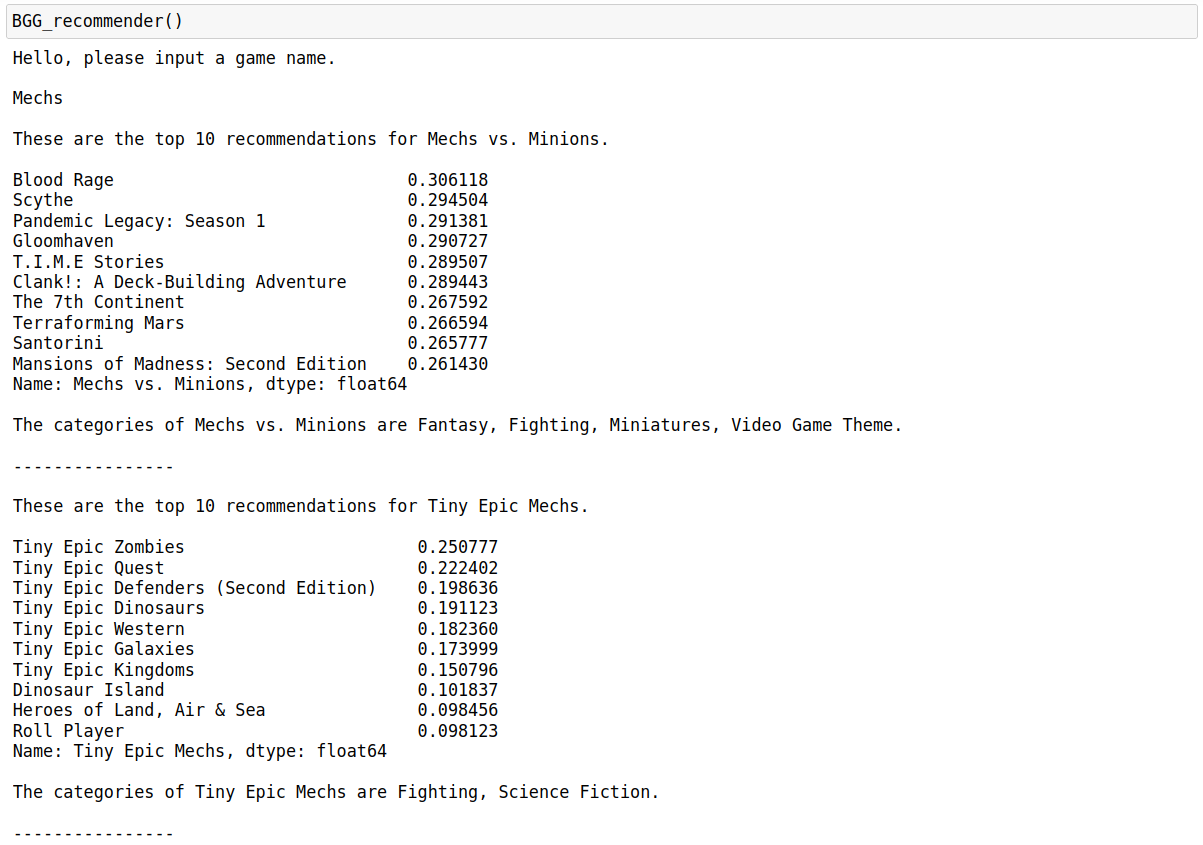

---

The results of the recommender system are as desired. To get a better model, it is recommended to gather more user data through web scraping. Some future objectives include implementing a categorical filter to get only games of a specific category and a title filter to choose games not in the same series. It would also be interesting to create  a user vector system that relates anyone using the model to the most similar user ID using personal ratings of games. For further information, the user can then be searched up using the BoardGameGeek website. One limitation of this is a requirement that the model user has already formed opinions about several games.